# Template to analyse CLM/CTSM output using the ctsm_py repo

*Inne Vanderkelen - July 2023*

This template contains some basic python commands to read in and analyse CLM output. It uses the [ctsm_python_gallery](https://github.com/NCAR/ctsm_python_gallery) repository of NCAR. 

**Prerequisites**: installation of a python environment, link to Jupyter kernel and ctsm_py package. [This](https://github.com/Ivanderkelen/wiki_tryout/wiki/CSCS#using-python-environments-for-jupyterhub-on-daint) and [this](https://github.com/Ivanderkelen/wiki_tryout/wiki/Community-Land-Model-(CLM)#the-ctsm_python_gallery-from-ncar-on-daint) wiki page explain how this can be done. 

## 1. Importing modules

In [26]:
import os

# load the utils from the ctsm python gallery
from ctsm_py.utils import *

## 2. Settings

### 2.1 Directory settings

In [27]:
# set directories - adapt with your name
outdir = "/scratch/snx3000/ivanderk/"

# Define directory where processing is done
procdir = outdir

# go to processing directory
os.chdir(procdir)

### 2.2 Load settings

In [28]:
# case name
case = "I2000Clm51Sp.hcru_hcru_mt13.4p1000_CTL_pft.20230712-1809"

# which block (component) and history stream to analyse
block = "lnd"
stream = "h0"

# List of variables to import
variables = ["QINFL", "EFLX_LH_TOT"]

# years to impport (this can be excluding spin up)
start_year = 2005
end_year = 2008

# based on year to import, defined timeslice
time_slice = slice(str(start_year) + "-01-01", str(end_year) + "-12-01")

### 2.3 Functions for importing 
nothing to change here, can be moved to your own functions file

In [29]:
# import dataset for specific case variables

def import_case(
    case,
    myVars=None,
    myVegtypes=None,
    timeSlice=None,
    myVars_missing_ok=[],
    only_active_patches=False,
    rename_lsmlatlon=False,
    chunks=None,
    alter_lons=True,
):

    # get file list
    filelist = get_filelist(case, stream=stream, block=block)
    
    
    # import ds (using function from ctsm_py)
    ds = import_ds(
        filelist,
        myVars=myVars,
        myVegtypes=None,
        timeSlice=timeSlice,
        myVars_missing_ok=[],
        only_active_patches=False,
        rename_lsmlatlon=False,
        chunks=None,
    )

    if alter_lons:
        # alter lons to span -180 to 180
        ds = lon_pm2idl(ds, fail_silently=False)

    return ds

In [30]:
# get list of files with their full paths 
def listdir_fullpath(d, stream=stream):
    return [os.path.join(d, f) for f in os.listdir(d) if stream in f]

# get a list of files to open ds from
def get_filelist(case, stream=stream, block=block):

    # Define directory where timeseries data is stored
    tseriesdir = outdir + 'CCLM2_output/' + case + '/' + block + '/hist/'
    
    # define filename
    filelist = listdir_fullpath(tseriesdir, stream=stream)
    
    return filelist

## 3. Load the case variables into an xarray DataSet

In [31]:
# import case 

ds = import_case(case, myVars=variables, timeSlice=time_slice,  alter_lons=True)

In [32]:
ds

<xarray.Dataset>
Dimensions:      (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1, time: 48,
                  hist_interval: 2, lon: 720, lat: 360)
Coordinates:
  * levgrnd      (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi       (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak       (levlak) float32 0.05 0.6 2.1 4.6 8.1 ... 18.6 25.6 34.33 44.78
  * levdcmp      (levdcmp) float32 1.0
  * time         (time) object 2005-01-01 00:00:00 ... 2008-12-01 00:00:00
  * lon          (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat          (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds  (time, hist_interval) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    EFLX_LH_TOT  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    QINFL        (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/39)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 07/12/23 20:41:17
    source:                               Community Terrestrial Systems Model
    hostname:                             pizdaint
    ...                                   ...
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./I2000Clm51Sp.hcru_hcru_mt13.4p100...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [47]:
# get latent heat flux as an xarray dataArray from the dataset 
da = ds['EFLX_LH_TOT']

In [48]:
da

<xarray.DataArray 'EFLX_LH_TOT' (time: 48, lat: 360, lon: 720)>
dask.array<rechunk-merge, shape=(48, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2008-12-01 00:00:00
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    long_name:      total latent heat flux [+ to atm]
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

## 4. Perform some basic analysis

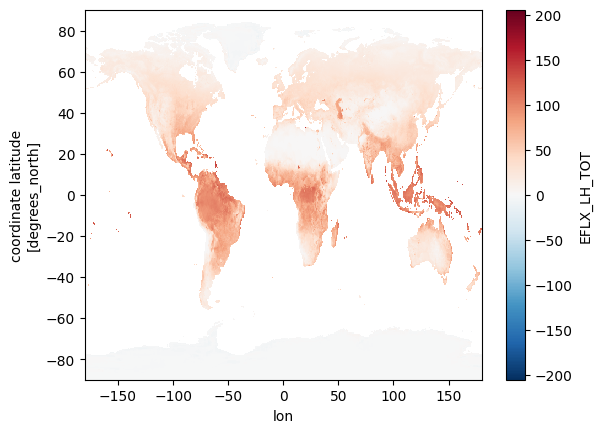

In [39]:
# plot time average

da.mean('time').plot()

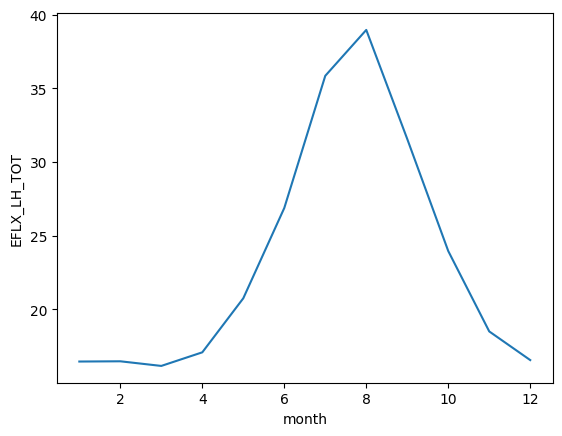

In [46]:
# caculate global mean time series
da_globmean = da.mean(dim=('lat','lon'))

# group by month of year and thake the mean
da_seas = da_globmean.groupby('time.month').mean()

# do plotting 
da_seas.plot()